In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data_dir = '/content/drive/MyDrive/APS360_Project_Data/train'

MLP

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler


In [12]:
# MLP for Traffic Sign Classification
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# Data transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images
    transforms.ToTensor(),        # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

def data_visualizer(train_loader_, title):
    """
    Visualizes the first 15 images from the data loader.

    Args:
        train_loader_: iterable training dataset organized according to batch size
        title: string that is the title of the resulting plots
    """
    plt.figure(figsize=(10, 6))
    k = 0
    for images, labels in train_loader_:
        # Retrieve the first image in the batch
        image = images[0]
        # Move the color channel to the end (from [C, H, W] to [H, W, C])
        img = np.transpose(image.numpy(), (1, 2, 0))

        # Denormalize the image (assuming it was normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225])
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        # Clip the values to be between 0 and 1 for display
        img = np.clip(img, 0, 1)

        # Plot the image
        plt.subplot(3, 5, k + 1)
        plt.suptitle(title)
        plt.axis('off')
        plt.imshow(img)

        k += 1
        if k > 14:
            break

    plt.tight_layout()
    plt.show()


def get_data_loaders(train_dataset, test_dataset, batch_size=32, val_split=0.15, shuffle=True, random_seed=1000):
    """
    Loads images from train and test directories, splits the train data into training and validation datasets,
    and returns data loaders for the three preprocessed datasets.

    Args:
        train_dir (str): Path to the training data directory.
        test_dir (str): Path to the testing data directory.
        batch_size (int): Number of samples per batch.
        val_split (float): Proportion of the training dataset to use for validation.
        shuffle (bool): Whether to shuffle the training data during DataLoader creation.
        random_seed (int): Random seed for reproducibility.

    Returns:
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        test_loader: DataLoader for the testing dataset.
    """
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)


    # Split the train_dataset into training and validation datasets
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_split * num_train))

    if shuffle:
        np.random.shuffle(indices)

    train_idx, val_idx = indices[split:], indices[:split]

    # Create subsets for training and validation
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, num_workers=2, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, num_workers=2, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

    return train_loader, val_loader, test_loader


def get_data_loader(data_set, batch_size=1, val_split=0.15, test_split=0.15, shuffle=True, random_seed=1000):
    """
    Loads images, splits the data into training, validation, and testing datasets,
    and returns data loaders for the three preprocessed datasets.

    Args:
        data_dir (str): Directory where data is stored. Classes should be subdirectories.
        batch_size (int): Number of samples per batch.
        val_split (float): Proportion of the dataset to use for validation.
        test_split (float): Proportion of the dataset to use for testing.
        shuffle (bool): Whether to shuffle the dataset before splitting.
        random_seed (int): Random seed for reproducibility.

    Returns:
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        test_loader: DataLoader for the testing dataset.
    """
    torch.manual_seed(1000)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_size = int(np.floor(val_split * dataset_size))
    test_size = int(np.floor(test_split * dataset_size))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices = indices[val_size + test_size:]
    val_indices = indices[:val_size]
    test_indices = indices[val_size:val_size + test_size]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=2)

    return train_loader, val_loader, test_loader

def get_data_loader_with_order(dataset, batch_size=1, val_split=0.2, test_split=0, shuffle=False, random_seed=1000):
    """
    Loads images, splits the data into training, validation, and testing datasets in order within each class,
    and returns data loaders for the three preprocessed datasets.

    Args:
        dataset (Dataset): A PyTorch dataset object that has a 'samples' attribute (e.g., ImageFolder).
        batch_size (int): Number of samples per batch.
        val_split (float): Proportion of each class to use for validation.
        test_split (float): Proportion of each class to use for testing.
        shuffle (bool): Whether to shuffle the training data during DataLoader creation.
        random_seed (int): Random seed for reproducibility.

    Returns:
        train_loader: DataLoader for the training dataset (with shuffle=True).
        val_loader: DataLoader for the validation dataset.
        test_loader: DataLoader for the testing dataset.
    """
    torch.manual_seed(random_seed)

    # Check if the dataset has a 'samples' attribute
    if not hasattr(dataset, 'samples'):
        raise ValueError("The dataset must have a 'samples' attribute (e.g., datasets.ImageFolder).")

    samples = dataset.samples  # List of (path, class_idx) tuples

    # Get the class_to_idx mapping
    class_to_idx = dataset.class_to_idx  # Dictionary mapping class names to indices
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Mapping from index to class name

    # Initialize lists for train, val, test indices
    train_indices = []
    val_indices = []
    test_indices = []

    # For each class, split the data in order
    for class_idx in sorted(idx_to_class.keys()):
        # Get indices of samples belonging to this class
        class_sample_indices = [i for i, s in enumerate(samples) if s[1] == class_idx]
        # Sort these indices according to filename
        class_sample_indices_sorted = sorted(class_sample_indices, key=lambda idx: samples[idx][0])
        # Compute split sizes
        n_samples = len(class_sample_indices_sorted)
        n_val = int(np.floor(val_split * n_samples))
        n_test = int(np.floor(test_split * n_samples))
        n_train = n_samples - n_val - n_test
        # Split indices
        train_indices.extend(class_sample_indices_sorted[:n_train])
        val_indices.extend(class_sample_indices_sorted[n_train:n_train + n_val])
        test_indices.extend(class_sample_indices_sorted[n_train + n_val:])

    # Shuffle the training indices if shuffle is True
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(train_indices)

    # Create Subsets
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    #test_subset = Subset(dataset, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, num_workers=2, shuffle=True)  # Shuffle training data
    val_loader = DataLoader(val_subset, batch_size=batch_size, num_workers=2, shuffle=True)
    #test_loader = DataLoader(test_subset, batch_size=batch_size, num_workers=2, shuffle=True)
    test_loader = None
    return train_loader, val_loader, test_loader

True


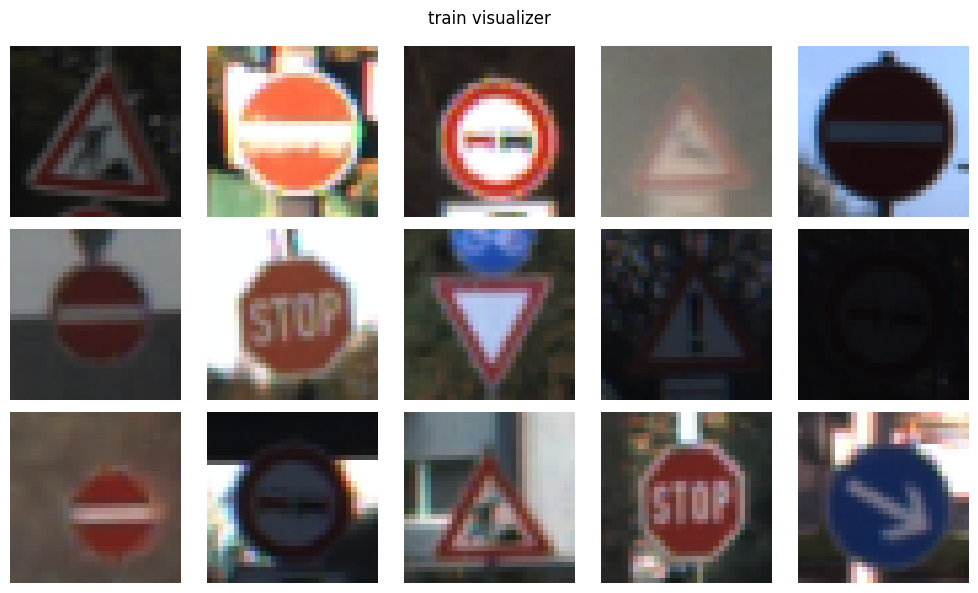

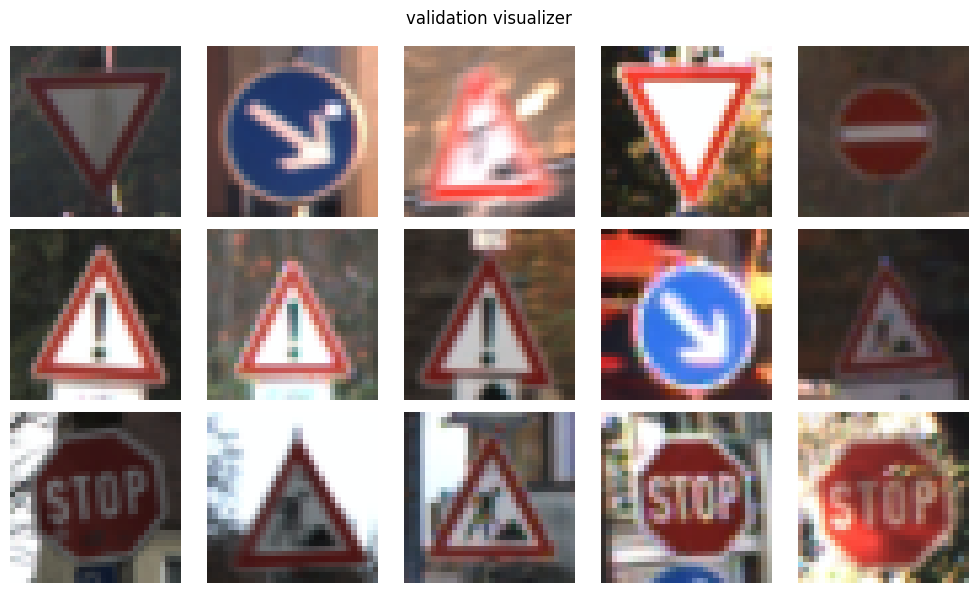

In [13]:
# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader, val_loader, test_loader = get_data_loader(dataset, batch_size=1, val_split=0.15, test_split=0.15, shuffle=True, random_seed=1000)
data_visualizer(train_loader, "train visualizer")
data_visualizer(val_loader, "validation visualizer")

In [14]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=150, num_classes=10):
        super(MLP, self).__init__()
        self.name = "MLP"
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MLP().to(device)

Validate that the model can overfit

Epoch [1/10], Loss: 2.4915, Accuracy: 0.00%
Epoch [2/10], Loss: 0.0008, Accuracy: 100.00%
Epoch [3/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [4/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [5/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [7/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0000, Accuracy: 100.00%


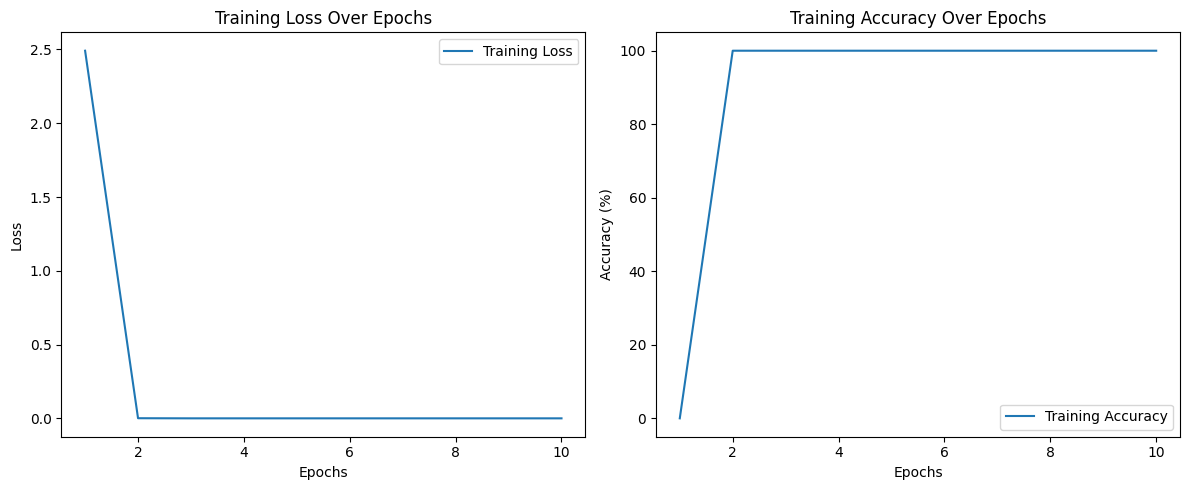

In [ ]:
##show that it can overfit
def get_overfit_dataloader(dataset, num_samples=10):
    """
    Returns a DataLoader for a small subset of the dataset (for overfitting).

    Args:
        dataset: The full dataset.
        num_samples: Number of samples to overfit on.

    Returns:
        DataLoader for the small subset of the dataset.
    """
    # Select a small number of samples
    small_indices = list(range(num_samples))
    small_sampler = SubsetRandomSampler(small_indices)

    # Return DataLoader for the small subset (batch size is the size of the small dataset)
    return DataLoader(dataset, batch_size=num_samples, sampler=small_sampler, shuffle=False)

def plot_training_progress_overfit(loss_list, accuracy_list):
    """
    Plots the training loss and accuracy curves.

    Args:
        loss_list: List of loss values at each epoch.
        accuracy_list: List of accuracy values at each epoch.
    """
    epochs = range(1, len(loss_list) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_list, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_list, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_overfit(model, overfit_loader, num_epochs=20, learning_rate=0.001):
    """
    Trains the model on a small dataset to demonstrate its ability to memorize the data.
    Also, plots the loss and accuracy curves.

    Args:
        model: The neural network model to train.
        overfit_loader: DataLoader for the small subset of data.
        num_epochs: Number of training epochs.
        learning_rate: Learning rate for the optimizer.
    """
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Lists to store loss and accuracy for plotting
    loss_list = []
    accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in overfit_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate and store epoch loss and accuracy
        epoch_loss = running_loss / len(overfit_loader)
        train_accuracy = 100 * correct / total
        loss_list.append(epoch_loss)
        accuracy_list.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        # Stop early if the model memorizes the dataset
        # if train_accuracy == 100.0:
        #     print("Model has successfully memorized the small dataset.")
        #     break

    # Plot the training loss and accuracy curves
    plot_training_progress_overfit(loss_list, accuracy_list)

# Usage example (assuming train_dataset is your original dataset):
# Initialize your model
model = MLP().to(device)

# Get DataLoader for overfitting a small subset of the dataset
overfit_loader = get_overfit_dataloader(dataset, num_samples=10)

# Train on the small dataset to check for overfitting
train_overfit(model, overfit_loader, num_epochs=10, learning_rate=0.001)


Training of MLP

In [20]:
# Function to generate the model's name based on hyperparameters
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}.pth".format(name, batch_size, learning_rate, epoch)
    return path

# Function to plot training and validation loss and accuracy
def plot_training_progress(train_loss_list, val_loss_list, train_acc_list, val_acc_list, num_epochs):
    epochs = range(1, num_epochs+1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_list, label='Training Accuracy')
    plt.plot(epochs, val_acc_list, label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


def train_model(dataset, model, num_epochs=30, learning_rate=0.01, batch_size=64, checkpoint_interval=5):
    """
    Train a model with dynamic data loading based on batch size.
    """
    train_loader, val_loader, test_loader = get_data_loader_with_order(dataset, batch_size=batch_size)
    torch.manual_seed(1000)
    # Initialize training components
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Data loaded")
    # Trackers for performance
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = get_model_name(model.name, batch_size, learning_rate, epoch+1)
            torch.save(model.state_dict(), checkpoint_path)
            # print(f"Checkpoint saved: {checkpoint_path}")

    plot_training_progress(train_loss_list, val_loss_list, train_acc_list, val_acc_list, num_epochs)


cuda
True
Data loaded
Epoch 1, Train Loss: 1.3544, Train Acc: 58.02%, Val Loss: 0.9789, Val Acc: 63.01%
Epoch 2, Train Loss: 0.4260, Train Acc: 87.67%, Val Loss: 0.7190, Val Acc: 75.39%
Epoch 3, Train Loss: 0.2428, Train Acc: 93.19%, Val Loss: 0.6368, Val Acc: 79.65%
Epoch 4, Train Loss: 0.1676, Train Acc: 96.24%, Val Loss: 0.6639, Val Acc: 78.55%
Epoch 5, Train Loss: 0.1602, Train Acc: 95.37%, Val Loss: 0.5239, Val Acc: 81.23%
Epoch 6, Train Loss: 0.1172, Train Acc: 97.46%, Val Loss: 0.4362, Val Acc: 85.49%
Epoch 7, Train Loss: 0.1014, Train Acc: 97.54%, Val Loss: 0.4915, Val Acc: 82.49%
Epoch 8, Train Loss: 0.0826, Train Acc: 98.17%, Val Loss: 0.4466, Val Acc: 85.73%
Epoch 9, Train Loss: 0.0713, Train Acc: 98.88%, Val Loss: 0.4713, Val Acc: 83.75%
Epoch 10, Train Loss: 0.0710, Train Acc: 98.27%, Val Loss: 0.4469, Val Acc: 85.57%
Epoch 11, Train Loss: 0.0589, Train Acc: 99.00%, Val Loss: 0.4147, Val Acc: 85.33%
Epoch 12, Train Loss: 0.0668, Train Acc: 98.39%, Val Loss: 0.4765, Val Acc

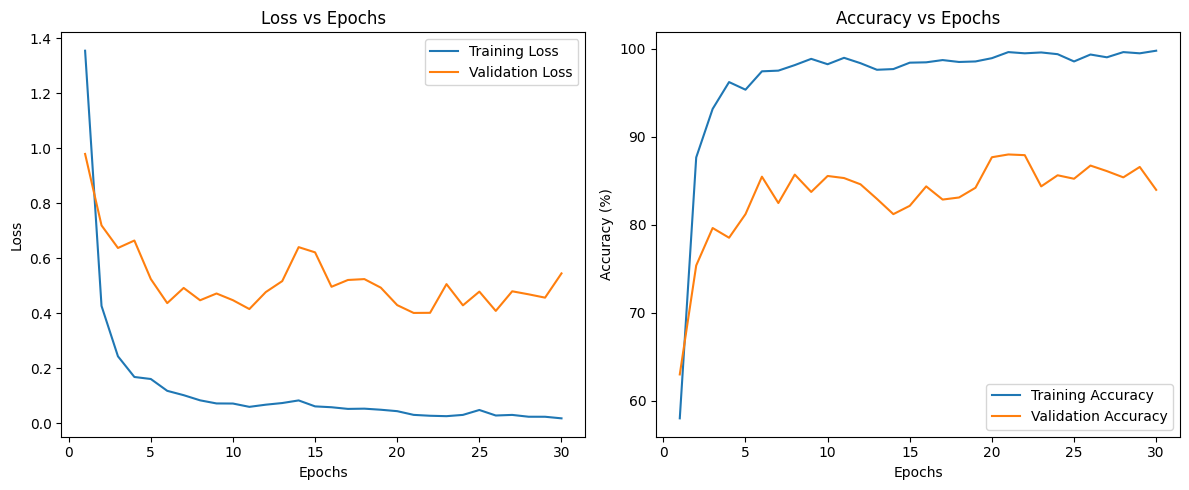

In [25]:
model = MLP().to(device)
print(device)
print(torch.cuda.is_available())
train_model(dataset, model, num_epochs=30, learning_rate=0.01, batch_size=256, checkpoint_interval=1)

In [26]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation/test set.
     Args:
         model: PyTorch neural network object
         loader: PyTorch data loader for the dataset
         criterion: The loss function
     Returns:
         error: A scalar for the avg classification error over the dataset
         loss: A scalar for the average loss over the dataset
     """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_error = 0.0
    total_elements = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_error += (predicted != labels).sum().item()
            total_elements += labels.size(0)

    error = total_error / total_elements
    avg_loss = total_loss / len(loader)
    return 1 - error, avg_loss



train_dir = '/content/drive/MyDrive/APS360_Project_Data/train'
test_dir = '/content/drive/MyDrive/APS360_Project_Data/test'
# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)


train_loader, val_loader, test_loader = get_data_loaders(train_dataset, test_dataset, batch_size=256)

model = MLP().to(device)
model.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = get_model_name(model.name, batch_size=256, learning_rate=0.01, epoch=21)
state = torch.load(model_path, weights_only=True)
model.load_state_dict(state)

# Set the appropriate criterion
criterion = nn.CrossEntropyLoss()

# Assuming val_loader and test_loader are properly defined
# val_acc, val_loss = evaluate(model, val_loader, criterion)
# print(f"The validation classification accuracy is {val_acc*100:.2f}%")
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f"The test classification accuracy is {test_acc*100:.2f}%")

The test classification accuracy is 86.83%


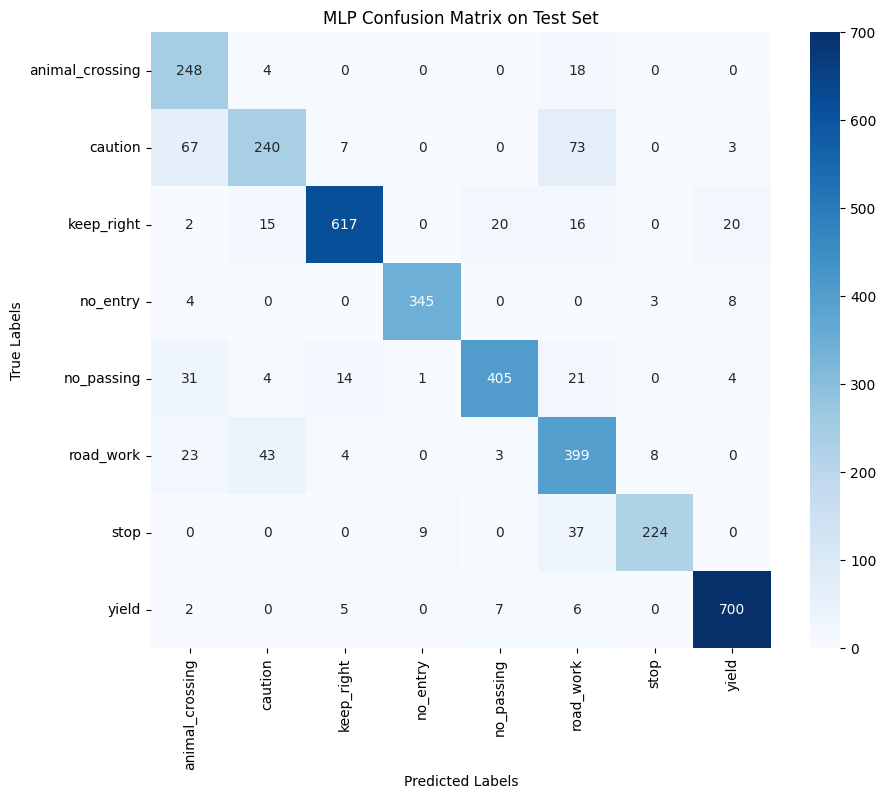

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Mapping of numeric labels to class names
label_mapping = {
    0: 'animal_crossing',
    1: 'caution',
    2: 'keep_right',
    3: 'no_entry',
    4: 'no_passing',
    5: 'road_work',
    6: 'stop',
    7: 'yield'
}

# Convert label mapping to a list of class names
class_names = list(label_mapping.values())

def evaluate_confusion(model, loader, criterion):
    # Collect all true labels and predictions
    all_labels = []
    all_predictions = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(model.device)
            labels = labels.to(model.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix with class names
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('MLP Confusion Matrix on Test Set')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

evaluate_confusion(model, test_loader, criterion)


Testing on a single image

<ipython-input-9-139962753f8e>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)  # Ensure map_location for CPU/GPU compa

Predicted class: 6


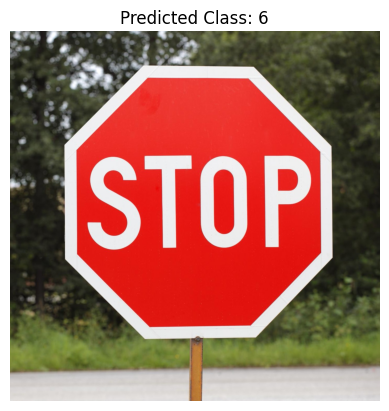

In [ ]:

import torch
from skimage import io, color, transform
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
image_path = "/content/drive/MyDrive/APS360_Project_Data/internet_image/stop/22e3132c89a1aee6cdbc650b429abb79.jpeg"
image = io.imread(image_path)

# If the image is grayscale or has an alpha channel, convert it to RGB
if image.ndim == 2:  # Grayscale image
    image = color.gray2rgb(image)
elif image.shape[2] == 4:  # RGBA image
    image = image[:, :, :3]  # Remove the alpha channel

# Resize the image to match the model input (32x32)
image_resized = transform.resize(image, (32, 32), anti_aliasing=True)

# Convert the image to a tensor and normalize it (if needed)
image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float().unsqueeze(0)  # Shape: (1, 3, 32, 32)

# Move the image tensor to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)

# Load the model and state dictionary
model = MLP().to(device)
model_path = get_model_name(model.name, batch_size=64, learning_rate=0.01, epoch=30)

# Load the model state
state = torch.load(model_path, map_location=device)  # Ensure map_location for CPU/GPU compatibility
model.load_state_dict(state)
model.eval()  # Set model to evaluation mode

# Run the model on the image
with torch.no_grad():  # Disable gradient computation for inference
    output = model(image_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Display the prediction result
print(f"Predicted class: {predicted_class}")

# Display the image
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()


Random Forest

In [ ]:
# Random Forest for Traffic Sign Classification using HOG Features
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, io, color
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm


Visualizing HOG features...


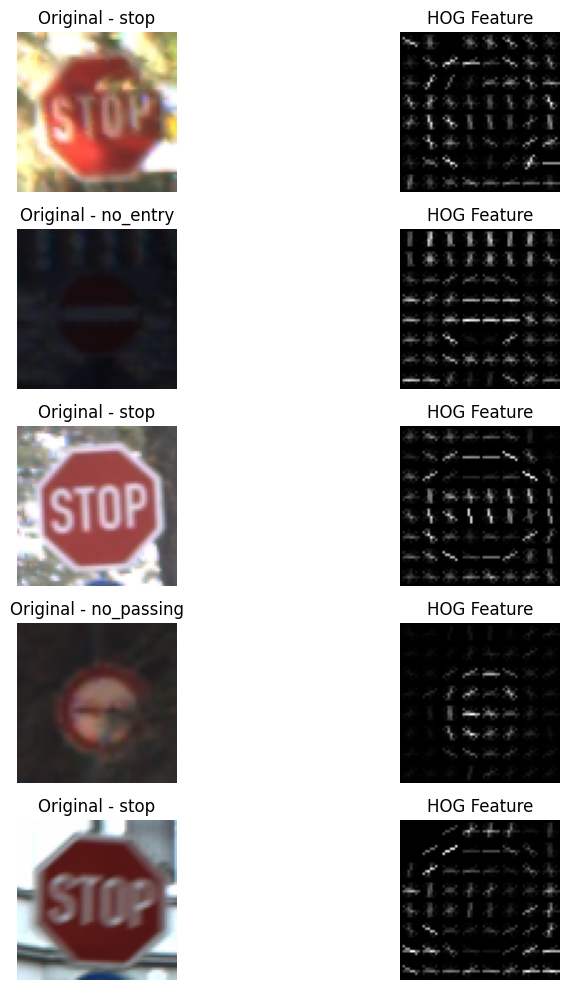

In [ ]:
# Visualize HOG features for some samples
print("Visualizing HOG features...")
num_samples = 5  # Number of samples to display
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

for idx in range(num_samples):
    # Select a random index from the dataset
    rand_idx = np.random.randint(len(X))

    # Retrieve the image path and label
    image_path = image_paths[rand_idx]
    image_class = y[rand_idx]

    # Read the image from the path
    image = io.imread(image_path)

    # Resize and convert the image to grayscale
    image = resize(image, image_size, anti_aliasing=True)
    image_gray = color.rgb2gray(image)

    # Recompute the HOG features for visualization
    _, hog_image = feature.hog(
        image_gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True
    )

    # Display the original image
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title(f'Original - {class_names[image_class]}')
    axes[idx, 0].axis('off')

    # Display the HOG feature image
    axes[idx, 1].imshow(hog_image, cmap='gray')
    axes[idx, 1].set_title('HOG Feature')
    axes[idx, 1].axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


Loading training data...


Processing yield: 100%|██████████| 800/800 [00:23<00:00, 34.03it/s] 


Loading test data...


Processing yield: 100%|██████████| 720/720 [00:20<00:00, 34.54it/s] 


Training Random Forest classifier...
Validation Accuracy: 99.58%
Test Accuracy: 98.14%

Classification Report:
                 precision    recall  f1-score   support

animal_crossing       0.97      1.00      0.99       270
        caution       0.98      0.93      0.95       390
     keep_right       0.99      1.00      1.00       690
       no_entry       1.00      0.94      0.97       360
     no_passing       0.95      1.00      0.97       480
      road_work       0.95      0.98      0.97       480
           stop       1.00      0.99      0.99       270
          yield       1.00      0.99      1.00       720

       accuracy                           0.98      3660
      macro avg       0.98      0.98      0.98      3660
   weighted avg       0.98      0.98      0.98      3660



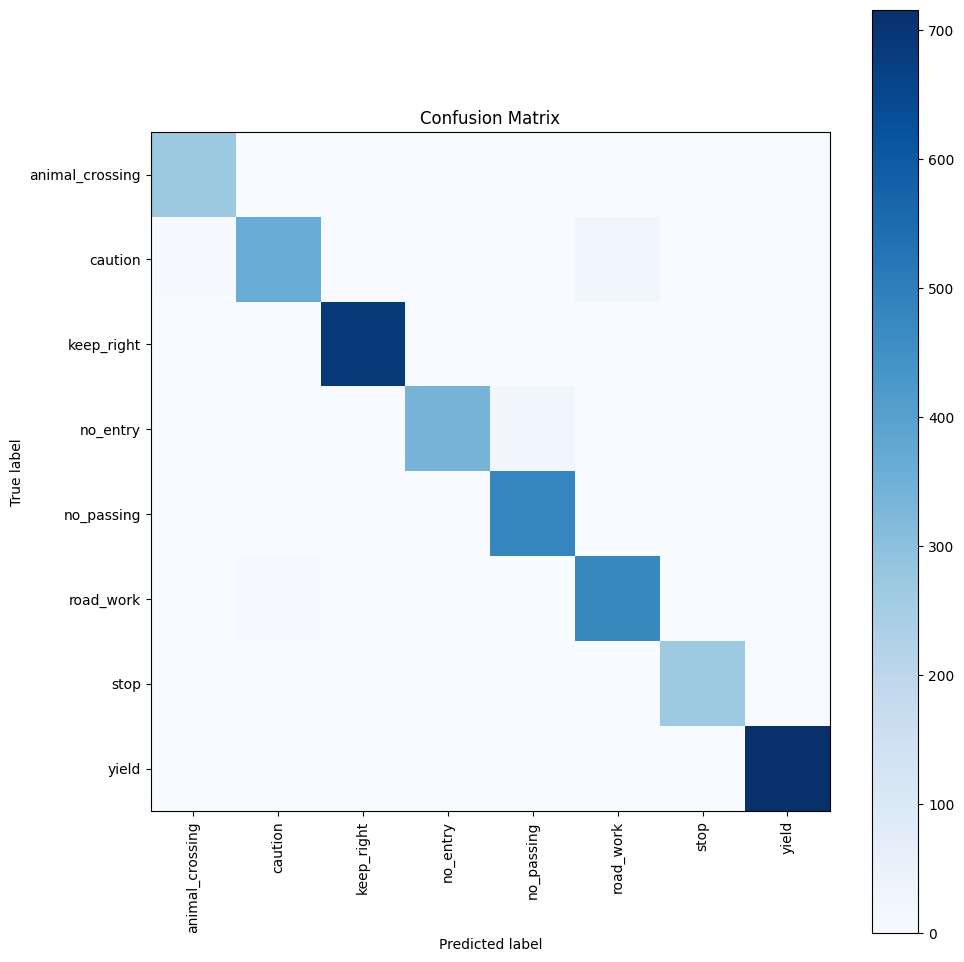

In [ ]:
import os
import numpy as np
from skimage import io, color
from skimage.transform import resize
from skimage import feature
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for HOG
image_size = (64, 64)
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

def load_data(data_dir, class_to_idx):
    X = []
    y = []
    for class_name in class_to_idx.keys():
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)
        for image_file in tqdm(image_files, desc=f'Processing {class_name}'):
            image_path = os.path.join(class_dir, image_file)
            image = io.imread(image_path)

            # Ensure image has three channels (RGB)
            if image.ndim == 2:  # Grayscale image
                image = color.gray2rgb(image)
            elif image.shape[2] == 4:  # RGBA image
                image = image[:, :, :3]

            image = resize(image, image_size, anti_aliasing=True)
            image_gray = color.rgb2gray(image)
            hog_feature = feature.hog(
                image_gray,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys'
            )
            X.append(hog_feature)
            y.append(class_to_idx[class_name])
    return np.array(X), np.array(y)

# Directories
train_dir = '/content/drive/MyDrive/APS360_Project_Data/train'
test_dir = '/content/drive/MyDrive/APS360_Project_Data/test'

# Get class names
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Create a mapping from class names to indices
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

# Load training data
print("Loading training data...")
X_train_full, y_train_full = load_data(train_dir, class_to_idx)

# Split training data into training and validation sets
val_split = 0.15
num_train = len(X_train_full)
indices = np.arange(num_train)
split = int(np.floor(val_split * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

X_train = X_train_full[train_idx]
y_train = y_train_full[train_idx]

X_valid = X_train_full[val_idx]
y_valid = y_train_full[val_idx]

# Load test data
print("Loading test data...")
X_test, y_test = load_data(test_dir, class_to_idx)

# Train Random Forest Classifier
print("Training Random Forest classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Validation accuracy
y_valid_pred = clf.predict(X_valid)
valid_acc = accuracy_score(y_valid, y_valid_pred)
print(f'Validation Accuracy: {valid_acc * 100:.2f}%')

# Test accuracy
y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Classification report
print('\nClassification Report:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


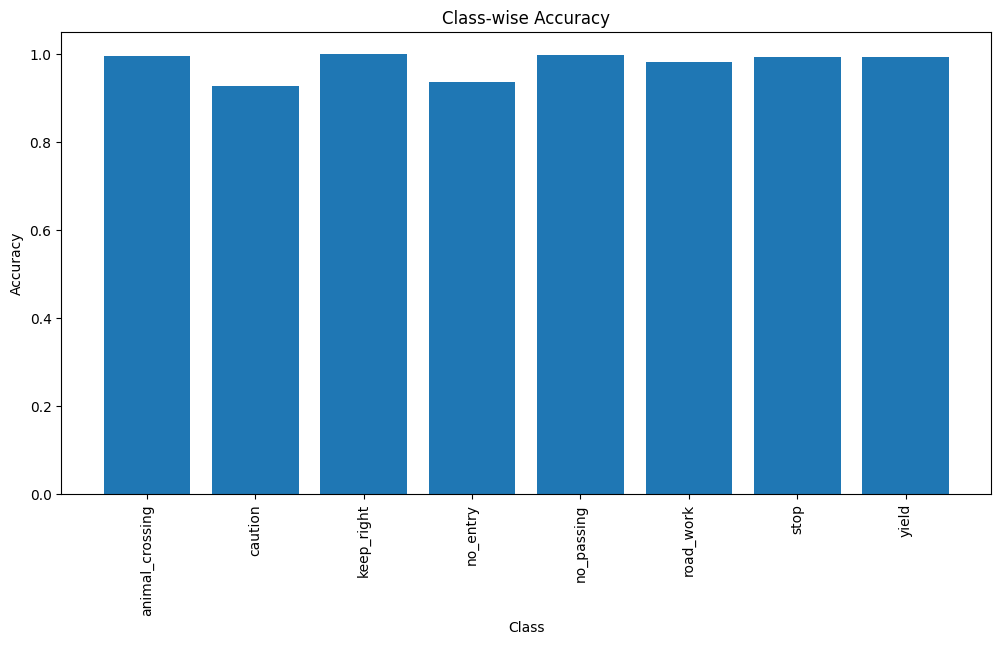

In [ ]:
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_accuracies)
plt.title('Class-wise Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.show()


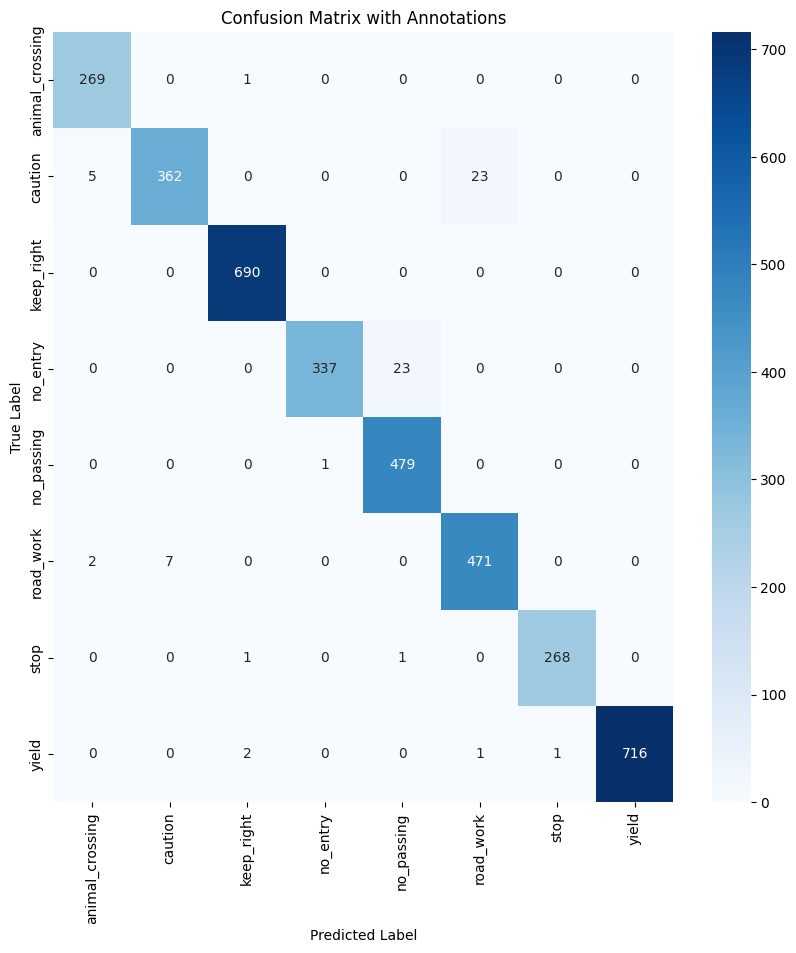

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `conf_mat` is your confusion matrix and `class_names` is a list of class labels
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix with Annotations')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
